In [1]:
import torch
import torchvision

from torch import nn 
from torchvision import transforms
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [3]:
# Pre-processing data
preprocess = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
from torch.utils.data import random_split, DataLoader

# Defining dataset
dataset = torchvision.datasets.ImageFolder(
    root='./images',
    transform=preprocess    
)

# Split train (0.8) and test (0.2) dataset
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

# Converting to dataloader to divide dataset into batches
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
# Importing the weights for the trained model resnet50 (50 layers)
resnet50_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

# Excluding the last layer - (fc): Linear(in_features=2048, out_features=1000, bias=True)
resnet50_model.fc = nn.Identity()

# Putting the resnet50 model in evaluation mode to avoid training keeping the default weights
for param in resnet50_model.parameters():
    param.requires_grad = False
resnet50_model.eval();

# Putting the resnet50 model to device
resnet50_model = resnet50_model.to(device)

In [6]:
# Creating a fully-connected model
fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
)

fc_model = fc_model.to(device)

# Combining the two models
model = nn.Sequential(
    resnet50_model,
    fc_model
)

model = model.to(device)

# Defining the optimizer (passing only the fc_model)
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)

# Defining the loss function
criterion = nn.BCEWithLogitsLoss()

In [7]:
# Training loop
train_losses = []
test_losses = []

for epoch in range(10):
    model.train()
    resnet50_model.eval() # Only training the model_fc

    train_loss_sum = 0
    for X, y in tqdm(train_dataloader):
        X = X.to(device)
        y = y.to(device).type(torch.float32).reshape(-1, 1)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
    train_losses.append(train_loss_sum / len(train_dataloader))

    print(f"Epoch: {epoch}, Loss: {train_loss_sum}")

    # Saving models for each iteration
    torch.save(fc_model.state_dict(), f"models/fc_model_{epoch}.pth")

    model.eval()
    test_loss_sum = 0
    with torch.no_grad():
        for X, y in tqdm(test_dataloader):
            X = X.to(device)
            y = y.to(device).type(torch.float32).reshape(-1, 1)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            test_loss_sum += loss.item()
        test_losses.append(test_loss_sum / len(test_dataloader))

100%|██████████| 47/47 [01:48<00:00,  2.31s/it]


Epoch: 0, Loss: 16.772698935121298


100%|██████████| 47/47 [01:47<00:00,  2.29s/it]


Epoch: 1, Loss: 10.194315534085035


100%|██████████| 47/47 [01:47<00:00,  2.29s/it]


Epoch: 2, Loss: 9.37797199189663


100%|██████████| 47/47 [01:47<00:00,  2.28s/it]


Epoch: 3, Loss: 8.91419018059969


100%|██████████| 47/47 [01:47<00:00,  2.28s/it]


Epoch: 4, Loss: 8.730372112244368


100%|██████████| 47/47 [01:46<00:00,  2.27s/it]


Epoch: 5, Loss: 7.984572421759367


100%|██████████| 47/47 [01:45<00:00,  2.25s/it]


Epoch: 6, Loss: 6.5952341090887785


100%|██████████| 47/47 [01:46<00:00,  2.26s/it]


Epoch: 7, Loss: 5.715567518025637


100%|██████████| 47/47 [01:45<00:00,  2.24s/it]


Epoch: 8, Loss: 7.624543555080891


100%|██████████| 47/47 [01:46<00:00,  2.26s/it]


Epoch: 9, Loss: 7.056338215246797


100%|██████████| 12/12 [00:27<00:00,  2.25s/it]


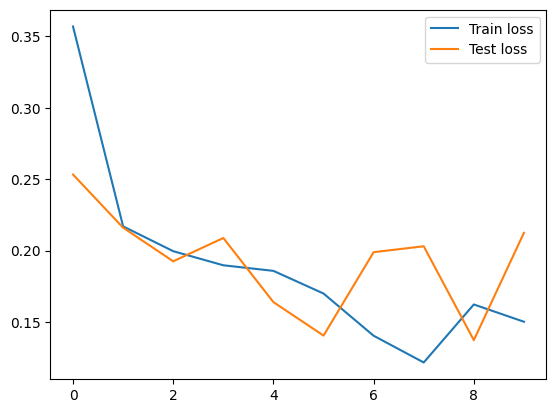

In [8]:
import matplotlib.pyplot as plt

# Examinating train and test loss

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [9]:
# Evaluating the model

model.eval()
with torch.no_grad():
    total = 0
    accurate = 0

    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device).type(torch.float32).reshape(-1, 1)
        
        # Apply the model
        y_pred = model(X)

        # Convert to 0 or 1
        predictions = (torch.sigmoid(y_pred) > 0.5).type(torch.float32)
        
        # Count corrects
        correct = (predictions == y).sum().item()
        accurate += correct
        total += y.size(0)

    accuracy = 100 * accurate / total
    print(f"Accuracy: {accuracy:.2f} %")

Accuracy: 90.84 %
